### Load Packages

In [1]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
#%matplotlib notebook
from IPython import display
import pandas as pd

import sys, subprocess
from PIL import Image
import pickle
from armcodlib import *
import keras.backend as K
import os
import cv2
from glob import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation


Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.0.0-alpha0


### Create arm positions dataset

Fixing parameters 

In [3]:
NB_POSTURE = 50
NB_COMMAND = 100
NB_DATA = NB_POSTURE*NB_COMMAND
BATCH_SIZE = 100
TEST_BUF = 1000
IMG_SIZE = 64
DIMS = (IMG_SIZE, IMG_SIZE,2)
N_TRAIN_BATCHES =int(NB_DATA/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)


Creation of the training data: 
- train_posture_before : joint angles before command
- train_posture_after  : joint angles after command is applied
- command : command applied
- train_position_before : end effector position before command
- train_position_after : end effector position after command is applied.

Saving the training data

Loading saved data (_not useful in general_)

In [4]:
train_images_pickle = open("pickles/train_images.pickle", "rb")
train_command_pickle = open("pickles/train_command.pickle", "rb")
train_posture_before_pickle = open("pickles/train_posture_before.pickle", "rb")
train_posture_after_pickle = open("pickles/train_posture_after.pickle", "rb")
train_position_before_pickle = open("pickles/train_position_before.pickle","rb")
train_position_after_pickle = open("pickles/train_position_after.pickle", "rb")



train_command = pickle.load(train_command_pickle)
train_images = pickle.load(train_images_pickle)
train_posture_before = pickle.load(train_posture_before_pickle)
train_posture_after = pickle.load(train_posture_after_pickle)
train_position_before = pickle.load(train_position_before_pickle)
train_position_after = pickle.load(train_position_after_pickle)

train_images_pickle.close()
train_command_pickle.close()
train_posture_after_pickle.close()
train_posture_before_pickle.close()
train_position_before_pickle.close()
train_position_after_pickle.close()

Creation of the tf.dataset

In [5]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,],train_images[:,:,:,1:]))
    .repeat(10)
    .shuffle(NB_DATA)
    .batch(BATCH_SIZE)
)

train_dataset_x = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,],train_images[:,:,:,:0]))
    .repeat(10)
    .shuffle(NB_DATA)
    .batch(BATCH_SIZE)
)

visu_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,]))
    .repeat(10)
    .shuffle(NB_DATA)
)

### Main convolutional model

Creation, compilation and training of the model.

In [6]:
encoder_conv = build_conv2D_pointwise_encoder()
decoder_dense = build_dense_pointwise_decoder()

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-3)

autoencoder_conv = tf.keras.Model(encoder_conv.input,
                                  decoder_dense(encoder_conv(encoder_conv.input)),
                                  name = "autoencoder")

autoencoder_conv.compile(optimizer = 'adam', 
                         loss='mse',
                         metrics=['accuracy','kullback_leibler_divergence'])

In [8]:
autoencoder_conv.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 2)]       0         
_________________________________________________________________
encoder_model (Model)        (None, 1, 64)             960352    
_________________________________________________________________
decoder_model (Model)        (None, 64, 64, 1)         139392    
Total params: 1,099,744
Trainable params: 1,099,744
Non-trainable params: 0
_________________________________________________________________


In [9]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = autoencoder_conv.fit(train_dataset, 
                    epochs = 10)#, 
                    #steps_per_epoch = 50)
                    #callbacks=[tensorboard_callback])

Epoch 1/10
500/500 [==============================] - 29s 57ms/step - loss: 0.0047 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0516
Epoch 2/10
500/500 [==============================] - 28s 55ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.0929
Epoch 3/10
500/500 [==============================] - 28s 55ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1042
Epoch 4/10
500/500 [==============================] - 28s 55ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1083
Epoch 5/10
500/500 [==============================] - 28s 55ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1099
Epoch 6/10
500/500 [==============================] - 28s 55ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - kullback_leibler_divergence: 0.1112
Epoch 7/10
500/500 [==============================] - 28s 55ms/step - loss: 0.0022 - accuracy: 0.0000e+00 - kullback_leibler_divergence:

Plot the loss function

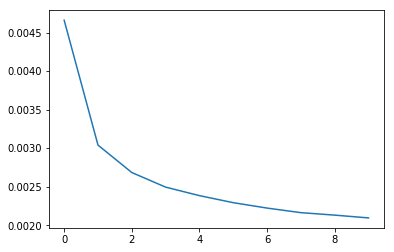

In [10]:
plt.plot(history.history['loss'])

Example of reconstructed image

In [11]:
example_data = next(iter(train_dataset))

In [12]:
res = encoder_conv.predict(example_data)

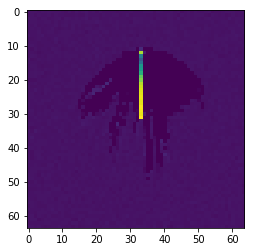

In [13]:
imshow(autoencoder_conv.predict(example_data)[0,:,:,0])

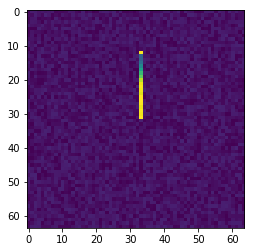

In [14]:
imshow(example_data[0][0,:,:,1])

### Visualization of ConvNet Filters

### Visualization of dense layers

### t-SNE 

### 3D t-SNE animation

## Control model

In [15]:
def control_model():
    """ visual_direction and posture before as input
        motor command as output
    """
    
    inputs = tf.keras.layers.Input(shape=(2,3))
    
    h = tf.keras.layers.Lambda(lambda x: x[:,0,:])(inputs)
    p = tf.keras.layers.Lambda(lambda x: x[:,1,:3])(inputs)
    
    h = tf.keras.layers.Reshape((1,3))(h)
    p = tf.keras.layers.Reshape((1,3))(p)

    fh = tf.keras.layers.Flatten()(h)
    fh = tf.keras.layers.Dense(32, name = 'dense_h_1')(fh)
    fh = tf.keras.layers.Dense(32, name = 'dense_h_2')(fh)
    fh = tf.keras.layers.Reshape((32, 1))(fh)
    
    fp = tf.keras.layers.Flatten()(p)
    fp = tf.keras.layers.Dense(32, name = 'dense_p_1')(fp)
    fp = tf.keras.layers.Dense(32, name = 'dense_p_2')(fp)
    fp = tf.keras.layers.Reshape((32,1))(fp)
    
    matmul = tf.keras.layers.Multiply()([fp, fh])
    
    fy = tf.keras.layers.Flatten()(matmul)
    fy = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_y_1')(fy)
    fy = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_y_2')(fy)
    fy = tf.keras.layers.Dense(3, name = 'latent_y_out')(fy)
    fy = tf.keras.layers.Reshape((1,3))(fy)
    
    outputs = fy 
    
    model = tf.keras.Model(inputs = inputs, outputs = outputs, name='control_model')
    
    return model 

In [16]:
model = control_model()

In [17]:
model.summary()

Model: "control_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 3)]       0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 3)            0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 3)            0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_11 (Reshape)            (None, 1, 3)         0           lambda_5[0][0]                   
______________________________________________________________________________________

In [18]:
optimizer = tf.keras.optimizers.Adam(1e-3)

model.compile(optimizer = 'adam', 
             loss='mae',
             metrics=['accuracy','kullback_leibler_divergence'])

In [19]:
train_control_dataset = prepare_dataset(train_command, 
                                        train_posture_before,
                                       train_posture_after, 
                                       train_position_after, 
                                       train_position_before)

In [20]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

history = model.fit(train_control_dataset, 
                    epochs = 10)

Epoch 1/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0691 - accuracy: 0.9884 - kullback_leibler_divergence: 0.4708
Epoch 2/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0571 - accuracy: 1.0000 - kullback_leibler_divergence: 0.2990
Epoch 3/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0568 - accuracy: 1.0000 - kullback_leibler_divergence: 0.2964
Epoch 4/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0568 - accuracy: 1.0000 - kullback_leibler_divergence: 0.2980
Epoch 5/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0567 - accuracy: 1.0000 - kullback_leibler_divergence: 0.2961
Epoch 6/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0567 - accuracy: 1.0000 - kullback_leibler_divergence: 0.2954
Epoch 7/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0567 - accuracy: 1.0000 - kullback_leibler_divergence: 0.2964
Epoch 8/10
500/500 [==============

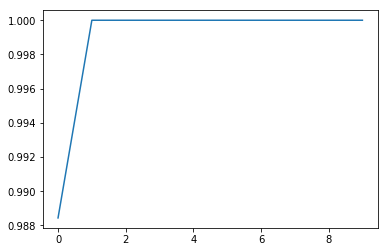

In [21]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.show()

Example


In [22]:
example_data = next(iter(train_control_dataset))
res = model.predict(example_data)
shape(example_data)
train_control_dataset

shape(res)
shape(example_data[1])
res - example_data[1]

<tf.Tensor: id=121548, shape=(100, 1, 3), dtype=float64, numpy=
array([[[-1.15954745e-01,  1.95750713e-01,  2.66049113e-02]],

       [[ 2.56900176e-02, -5.68764324e-02,  2.92154095e-02]],

       [[ 8.73407255e-02, -1.56085417e-01,  5.26845217e-02]],

       [[-5.93425688e-02,  1.23985249e-01,  1.02094301e-02]],

       [[-4.31307937e-02,  7.86775419e-02,  5.29077070e-03]],

       [[ 4.99651865e-03,  3.80714810e-04, -3.87350236e-03]],

       [[-2.50464531e-02,  2.81670305e-02,  5.22625016e-02]],

       [[ 9.59719698e-04, -1.86523153e-02, -1.98237144e-03]],

       [[ 5.16432356e-02, -1.13888309e-01,  5.75177431e-02]],

       [[ 2.07882476e-02, -3.49165813e-03,  2.12547708e-02]],

       [[-8.52529722e-02,  1.63808018e-01,  1.05413032e-02]],

       [[ 1.50339787e-01, -2.34622114e-01,  5.14760547e-02]],

       [[ 1.82320663e-03,  6.75635214e-03,  4.15568340e-03]],

       [[ 3.44535062e-03,  8.84087569e-02, -4.55809512e-03]],

       [[-5.79895659e-03,  5.21249928e-02,  1.60499620

#### Control model 

In [143]:
def test_visuomotor_control(control_model, visual_direction):
    # liste des postures successives
    postures = []
    # choisir une posture initiale
    #posture = (np.random.random((1,3)))
    posture = np.array([[0.3,0.3,0.2]])
    postures.append(posture)

    for i in range(400):
        tmp = posture

        inputs = np.concatenate([visual_direction, tmp], axis = 0)
        inputs = np.expand_dims(inputs, 0)

        command = control_model.predict(inputs)
        print command
        posture = posture + command[0]
        posture = check_valid_posture(posture)
        postures.append(posture)

    return postures
 
def check_valid_posture(posture):
    valid_posture = np.zeros(shape(posture))
    
    valid_posture[0][0] = math.fmod(posture[0][0],2*pi)
    valid_posture[0][1] = math.fmod(posture[0][1], pi)
    valid_posture[0][2] = math.fmod(posture[0][2], pi)

    return valid_posture
            

In [144]:
postures = test_visuomotor_control(model, [[0.9,0.1,0]] )


[[[-0.21356773  0.04750169  0.57567924]]]
[[[-0.09894903  0.02095336  0.57787853]]]
[[[ 0.01619419 -0.0049642   0.57982844]]]
[[[ 0.1318082  -0.03023236  0.58152676]]]
[[[ 0.24783881 -0.05483278  0.5829713 ]]]
[[[ 0.3642314  -0.07874724  0.58416027]]]
[[[-0.14537857  0.03546715  0.5756966 ]]]
[[[-0.03072696  0.00937234  0.5777425 ]]]
[[[ 0.0844159  -0.01608204  0.5795383 ]]]
[[[ 0.19999619 -0.04087766  0.58108187]]]
[[[ 0.3159594  -0.06499624  0.5823714 ]]]
[[[-0.19405818  0.04900518  0.57400924]]]
[[[-0.07979262  0.02268859  0.57615817]]]
[[[ 0.03498624 -0.00299638  0.5780582 ]]]
[[[ 0.15022479 -0.02803124  0.5797073 ]]]
[[[ 0.26586914 -0.05239771  0.58110344]]]
[[[-0.24444464  0.06134719  0.5728491 ]]]
[[[-0.1304521   0.0347657   0.57510686]]]
[[[-0.01592283  0.00880741  0.57711685]]]
[[[ 0.09908983 -0.01650909  0.57887685]]]
[[[ 0.21453203 -0.04116544  0.5803848 ]]]
[[[ 0.3303494  -0.06514345  0.5816388 ]]]
[[[-0.1798219   0.04899973  0.5732413 ]]]
[[[-0.06571783  0.02282618  0.5753

[[[ 0.23610409 -0.01568622  0.5740685 ]]]
[[[ 0.350502  -0.0390741  0.5752461]]]
[[[-0.16110668  0.07565496  0.56677526]]]
[[[-0.04845709  0.05006287  0.56881857]]]
[[[0.06468156 0.02509876 0.5706161 ]]]
[[[0.1782562  0.00078082 0.572166  ]]]
[[[ 0.29221368 -0.02287305  0.57346624]]]
[[[-0.21980913  0.09157987  0.5651193 ]]]
[[[-0.1075473   0.06570141  0.56728816]]]
[[[0.00523056 0.04044084 0.5692126 ]]]
[[[0.11847179 0.01581629 0.5708906 ]]]
[[[ 0.23212309 -0.00815401  0.5723201 ]]]
[[[ 0.34613127 -0.03145235  0.57349944]]]
[[[-0.16586721  0.08336379  0.565031  ]]]
[[[-0.05360714  0.05785617  0.5670777 ]]]
[[[0.05914225 0.03297387 0.56887966]]]
[[[0.17232849 0.00873503 0.5704347 ]]]
[[[ 0.28589815 -0.0148425   0.57174087]]]
[[[-0.2265114   0.09968398  0.56340104]]]
[[[-0.11463496  0.07387621  0.56557757]]]
[[[-0.00224132  0.0486834   0.5675107 ]]]
[[[0.11061721 0.02412381 0.5691984 ]]]
[[[2.2388770e-01 2.1535717e-04 5.7063854e-01]]]
[[[ 0.33751708 -0.02302423  0.5718291 ]]]
[[[-0.1748

In [25]:
t_visual_direction = (train_position_after - train_position_before)/(np.linalg.norm(train_position_after - train_position_before))
tmp = normalize_vect(t_visual_direction)
print norm(tmp[0])

1.0


In [173]:
def plot_arm_from_posture(posture):
    """function ploting and saving in /images 3d arm plot
    from arg joint state

    Args :
        phi1, phi2, theta1 : joint angles (3 dof arm )

    Returns :
        ax : a matplotlib figure object
    """
    phi1 = posture[0][0]
    phi2 = posture[0][1]
    theta1 = posture[0][2]
    
    fig = figure(facecolor=(0.0, 0.0, 0.0))
    ax = fig.gca(projection='3d')
    x = [0, 0, L1 * cos(phi1) * cos(theta1), L2 *
         cos(phi1 + phi2) * cos(theta1)]
    y = [0, 0, L1 * cos(phi1) * sin(theta1), L2 *
         cos(phi1 + phi2) * sin(theta1)]  # ELBOW + HAND
    z = [0, 0, L1 * sin(phi1), L2 * sin(phi1 + phi2)]  # ELBOW + HAND
    # ax.plot(x[0:1], y[0:1], z[0:1], label='shoulder', lw=2, color= 'k')
    # ax.plot(x[2:3], y[2:3], z[2:3], label='elbow', lw=2, color= 'c')
    # Hide grid lines
    #ax.grid(False)
    # ax.set_autoscale_on(True)
    #ax.set_facecolor((0.0, 0.0, 0.0))

    ax.set_xlim(left=-0.2, right=0.2)
    ax.set_ylim(bottom=-0.2, top=0.2)
    ax.set_zlim(bottom=-0.2, top=0.2)
    #ax.axis('off')
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.plot(x, y, z, label='shoulder', lw=5, color='blue')
    ax.scatter(-0.13,0.24,0.1, color= 'red', linewidths=5)
    #filename = 'images/%s.png' % time
    #savefig(filename, facecolor=fig.get_facecolor(), edgecolor='none')
    
def plot_elbow_from_posture(posture):
    """function ploting and saving in /images 3d arm plot
    from arg joint state

    Args :
        phi1, phi2, theta1 : joint angles (3 dof arm )

    Returns :
        ax : a matplotlib figure object
    """
    phi1 = posture[0][0]
    phi2 = posture[0][1]
    theta1 = posture[0][2]
    
    fig = figure(facecolor=(0.0, 0.0, 0.0))
    ax = fig.gca(projection='3d')
    x = [0, 0, L1 * cos(phi1) * cos(theta1)]
    y = [0, 0, L1 * cos(phi1) * sin(theta1)]  # ELBOW + HAND
    z = [0, 0, L1 * sin(phi1)]  # ELBOW + HAND
    # ax.plot(x[0:1], y[0:1], z[0:1], label='shoulder', lw=2, color= 'k')
    # ax.plot(x[2:3], y[2:3], z[2:3], label='elbow', lw=2, color= 'c')
    # Hide grid lines
    ax.grid(False)
    # ax.set_autoscale_on(True)
    ax.set_facecolor((0.0, 0.0, 0.0))

    ax.set_xlim(left=-0.2, right=0.2)
    ax.set_ylim(bottom=-0.2, top=0.2)
    ax.set_zlim(bottom=-0.2, top=0.2)
    ax.axis('off')
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.plot(x, y, z, label='shoulder', lw=5, color='white')
    ax.scatter(-0.5,-0.5,0.1, 'r')
    #filename = 'images/%s.png' % time
    #savefig(filename, facecolor=fig.get_facecolor(), edgecolor='none')
    


<IPython.core.display.Javascript object>


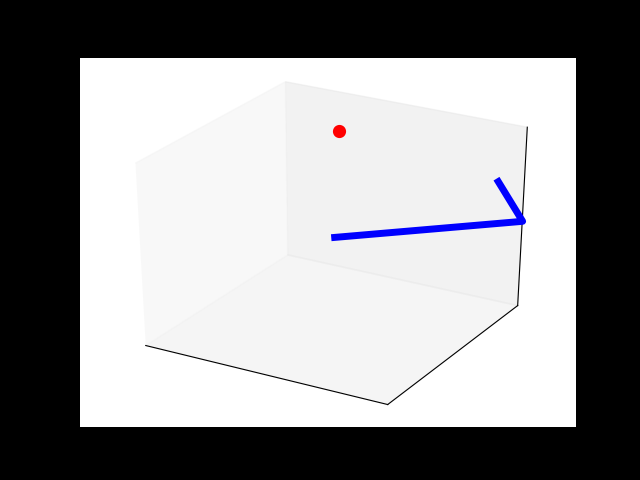

<IPython.core.display.Javascript object>


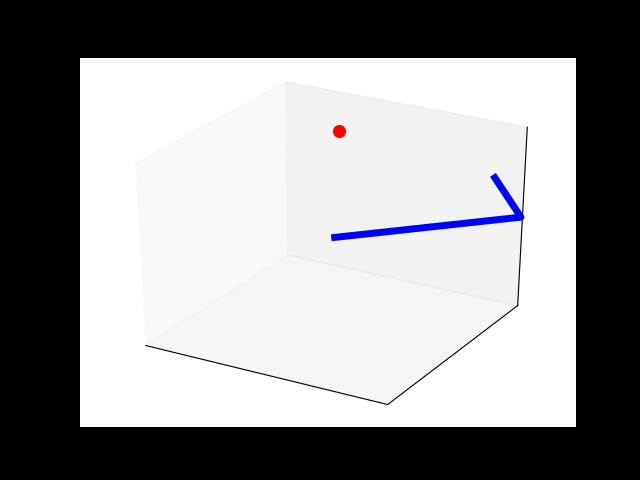

<IPython.core.display.Javascript object>


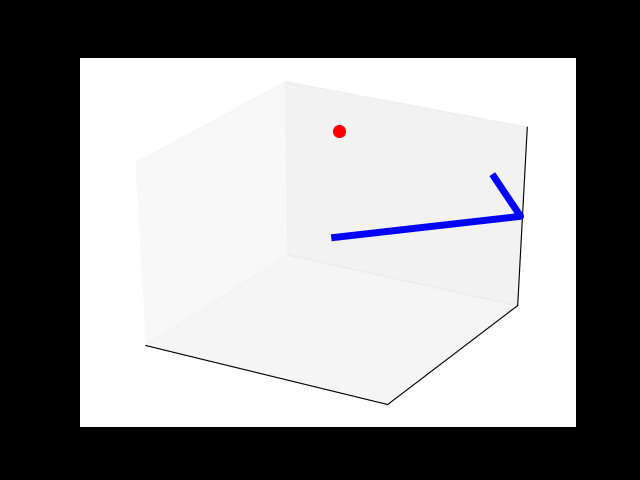

<IPython.core.display.Javascript object>


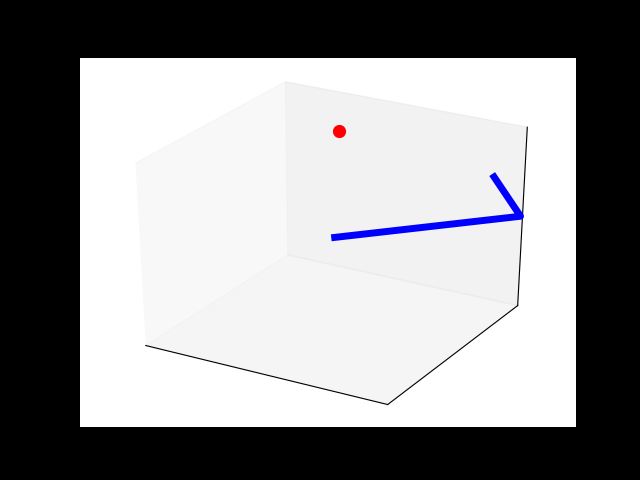

<IPython.core.display.Javascript object>


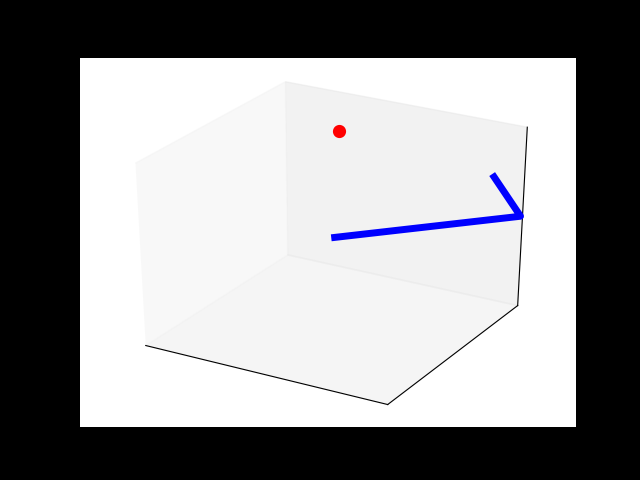

<IPython.core.display.Javascript object>


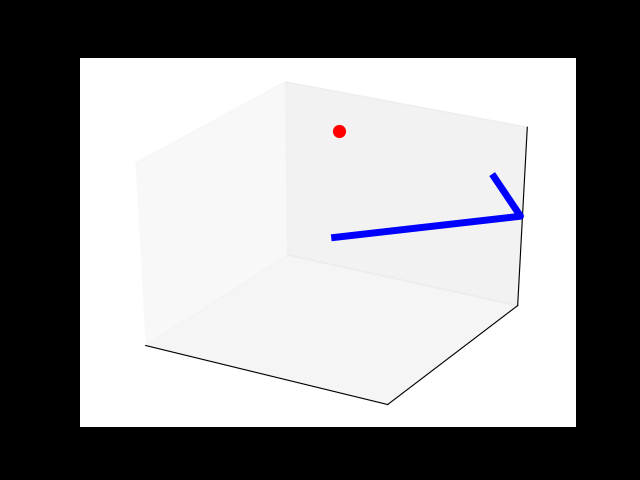

<IPython.core.display.Javascript object>


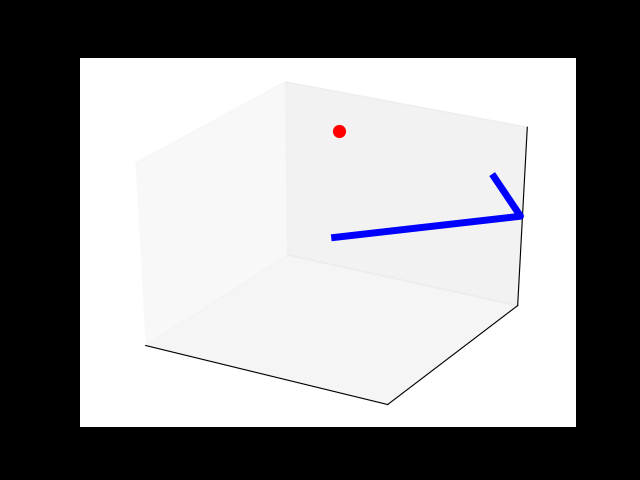

<IPython.core.display.Javascript object>


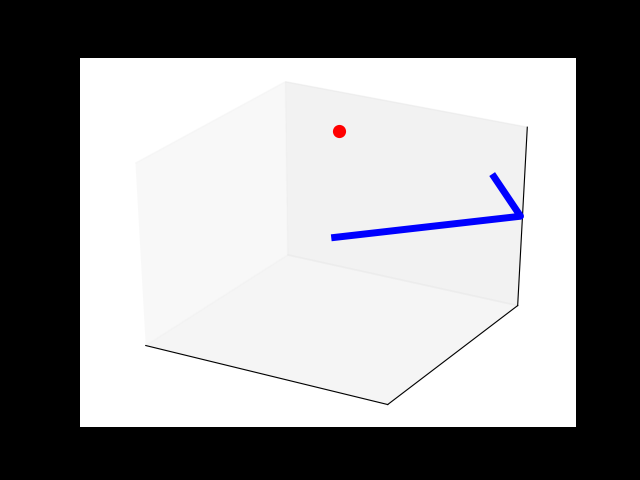

<IPython.core.display.Javascript object>


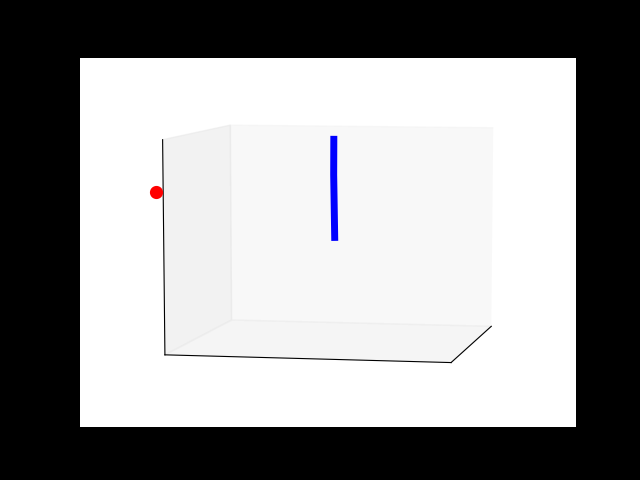

<IPython.core.display.Javascript object>


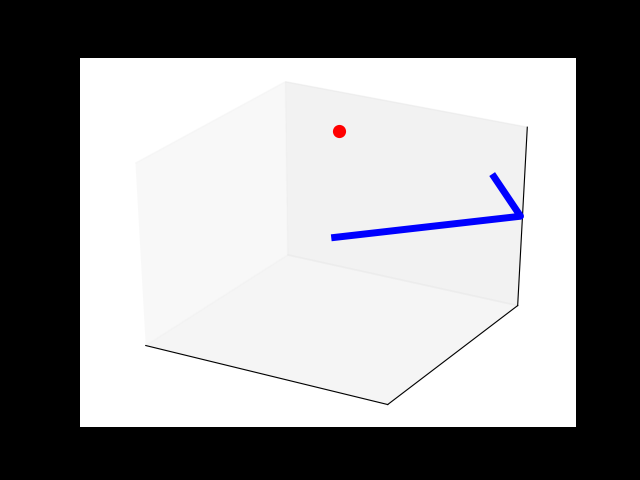

In [182]:
for i in range(10):
    plot_arm_from_posture(postures[5*i])

In [28]:
def control_robot_1(angles):
    """function calculating end effector postion from joint angles

    Args :
        phi1, phi2, theta1, theta2 : joint angles (4 dof arm )

    Returns:
        x,y,z : end effector position
        vx,vy,vz : speed i guess...
    """
    phi1, phi2, theta1 = angles
    theta2 = 0
    x = L1 * cos(phi1) * cos(theta1) + L2 * cos(phi1 + phi2) * \
        cos(theta1 + theta2)  # ELBOW + HAND
    y = L1 * cos(phi1) * sin(theta1) + L2 * cos(phi1 + phi2) * \
        sin(theta1 + theta2)  # ELBOW + HAND
    z = L1 * sin(phi1) + L2 * sin(phi1 + phi2)  # ELBOW + HAND
    vx = L2 * cos(phi1 + phi2) * cos(theta1 + theta2)
    vy = L2 * cos(phi1 + phi2) * sin(theta1 + theta2)
    vz = L2 * sin(phi1 + phi2)
    return [x, y, z]

def control_robot_elbow(angles):
    phi1, phi2, theta1 = angles
    x = L1 * cos(phi1) * cos(theta1)
    y = L1 * cos(phi1) * sin(theta1)
    z = L1 * sin(phi1)
    return np.array([x,y,z])

In [29]:
def compute_trajectory(postures):
    tmp = []
    for i in range(len(postures)):
        tmp.append(control_robot_1(postures[i][0]))
    return np.array(tmp)


def compute_elbow_trajectory(postures):
    tmp = []
    for i in range(len(postures)):
        tmp.append(control_robot_elbow(postures[i][0]))
    return np.array(tmp)



In [42]:
t = compute_trajectory(postures)
print shape(t)

(401, 3)


<IPython.core.display.Javascript object>


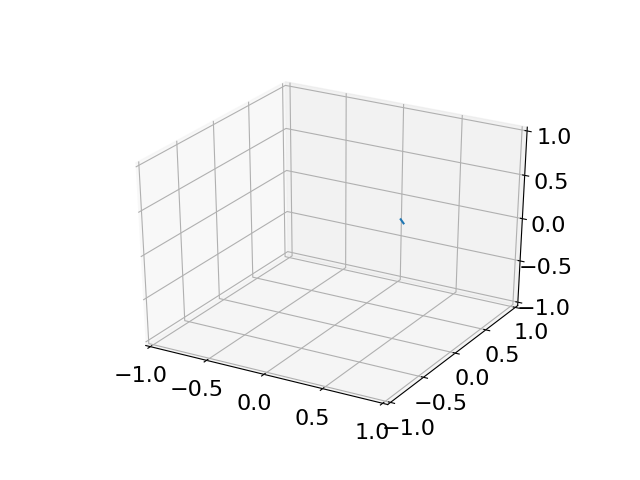

In [83]:
%matplotlib notebook

fig = plt.figure()

ax = plt.axes(projection='3d')
ax.set_xlim(left=-1, right=1)
ax.set_ylim(bottom=-1, top=1)
ax.set_zlim(bottom=-1, top=1)
ax.plot(t[:2,0], t[:2,1], t[:2,2])

In [37]:
def go_to_position(control_model, target_position):
    postures = []
    vd = []
    current_posture = np.array([[0.3,0.3,0.2]])

    visual_direction = compute_vd_from_position(target_position, current_posture)
    
    postures.append(current_posture)
    vd.append(np.linalg.norm(visual_direction))
    j = 0
    while  (j < 500):
        
        inputs = np.expand_dims(np.concatenate([visual_direction, current_posture], axis=0), 0)
        
        new_command = control_model.predict(inputs)
        #print new_command
        new_command = command_bornee(new_command)
        current_posture = current_posture + new_command[0]
        current_posture = check_valid_posture(current_posture)
        
        visual_direction = compute_vd_from_position(target_position, current_posture)
        print visual_direction
        postures.append(current_posture)
        vd.append(np.linalg.norm(visual_direction))
        visual_direction = compute_vd_from_position(target_position, current_posture)/np.linalg.norm(visual_direction)
        j += 1
        
    return postures, vd
        
def compute_vd_from_position(target_position, current_posture):
    
    current_position = control_robot_1(current_posture[0])
    current_position  = np.expand_dims(current_position, 0)
    return (target_position-current_position)

def is_distance_end_effector_to_target_ok(visual_direction):
    dx, dy, dz = visual_direction[0]
    
    dist = np.sqrt(dx*dx+dy*dy+dz*dz)
    
    return (dist > 0.01)
    
def command_bornee(command):
    new_command = np.zeros(shape(command))
    for i in range(3):
        if command[0][0][i] > 2:
            new_command[0][0][i] = 2
        elif command[0][0][i] < -2:
            new_command[0][0][i] = -2
        else :
            new_command[0][0][i] = command[0][0][i]
        return new_command

In [175]:
postures, vd = go_to_position(model, [[-0.13,0.24,0.1]])
t = compute_trajectory(postures)
t = np.array(t)

[[-0.65440573  0.1336977  -0.15624016]]
[[-0.6505715   0.13447493 -0.16425432]]
[[-0.64811246  0.13497341 -0.16923868]]
[[-0.64653432  0.13529331 -0.17237727]]
[[-0.64552079  0.13549876 -0.17436905]]
[[-0.64486952  0.13563078 -0.17563929]]
[[-0.64445086  0.13571565 -0.17645191]]
[[-0.64418166  0.13577022 -0.17697282]]
[[-0.64400852  0.13580531 -0.17730719]]
[[-0.64389715  0.13582789 -0.17752199]]
[[-0.64382552  0.13584241 -0.17766004]]
[[-0.64377944  0.13585175 -0.17774881]]
[[-0.64374979  0.13585776 -0.1778059 ]]
[[-0.64373073  0.13586163 -0.1778426 ]]
[[-0.64371844  0.13586412 -0.17786624]]
[[-0.64371055  0.13586572 -0.17788143]]
[[-0.64370547  0.13586675 -0.1778912 ]]
[[-0.6437022   0.13586741 -0.1778975 ]]
[[-0.64370009  0.13586784 -0.17790155]]
[[-0.64369874  0.13586811 -0.17790415]]
[[-0.64369788  0.13586829 -0.17790582]]
[[-0.64369732  0.1358684  -0.17790689]]
[[-0.64369696  0.13586847 -0.17790758]]
[[-0.64369673  0.13586852 -0.17790803]]
[[-0.64369658  0.13586855 -0.17790831]]


[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369631  0.1358686  -0.17790883]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369631  0.1358686  -0.17790883]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369631  0.1358686  -0.17790883]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369631  0.1358686  -0.17790883]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369631  0.1358686  -0.17790883]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369631  0.1358686  -0.17790883]]
[[-0.64369632  0.1358686  -0.17790882]]
[[-0.64369632  0.1358686  -0.17790882]]


<IPython.core.display.Javascript object>


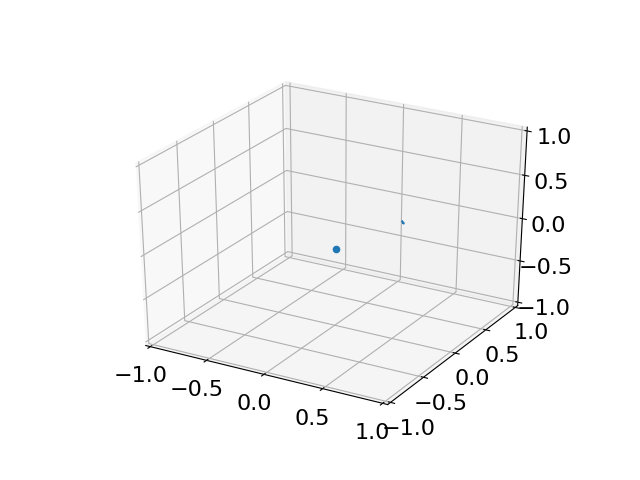

In [176]:
%matplotlib notebook

fig = plt.figure()

ax = plt.axes(projection='3d')
ax.set_xlim(left=-1, right=1)
ax.set_ylim(bottom=-1, top=1)
ax.set_zlim(bottom=-1, top=1)
ax.plot(t[:,0], t[:,1], t[:,2])
ax.scatter(-0.13,0.24,-0.3)


#### Error between asked and executed constant visual direction mvmt 

In [177]:
def calcul_angular_error(position, direction_visuelle):
    return np.arccos(np.dot(position, direction_visuelle)/(np.linalg.norm(position)*np.linalg.norm(direction_visuelle)))
def calcul_position_error(position, target):
    print position
    return np.linalg.norm(position-target)

In [180]:
errors = []
for i in range(400):
    position = t[i]
    direction_visuelle = [0.9,0.1,0] #vd[i]
    #error = calcul_angular_error(position, direction_visuelle)
    error = calcul_position_error(position, [-0.13,0.24,0.3])
    errors.append(error)
errors

[0.52355316 0.10612948 0.2580488 ]
[0.52440573 0.1063023  0.25624016]
[0.5205715  0.10552507 0.26425432]
[0.51811246 0.10502659 0.26923868]
[0.51653432 0.10470669 0.27237727]
[0.51552079 0.10450124 0.27436905]
[0.51486952 0.10436922 0.27563929]
[0.51445086 0.10428435 0.27645191]
[0.51418166 0.10422978 0.27697282]
[0.51400852 0.10419469 0.27730719]
[0.51389715 0.10417211 0.27752199]
[0.51382552 0.10415759 0.27766004]
[0.51377944 0.10414825 0.27774881]
[0.51374979 0.10414224 0.2778059 ]
[0.51373073 0.10413837 0.2778426 ]
[0.51371844 0.10413588 0.27786624]
[0.51371055 0.10413428 0.27788143]
[0.51370547 0.10413325 0.2778912 ]
[0.5137022  0.10413259 0.2778975 ]
[0.51370009 0.10413216 0.27790155]
[0.51369874 0.10413189 0.27790415]
[0.51369788 0.10413171 0.27790582]
[0.51369732 0.1041316  0.27790689]
[0.51369696 0.10413153 0.27790758]
[0.51369673 0.10413148 0.27790803]
[0.51369658 0.10413145 0.27790831]
[0.51369649 0.10413143 0.27790849]
[0.51369642 0.10413142 0.27790863]
[0.51369638 0.104131

[0.6684406912682734,
 0.6693555500602593,
 0.6652853011545422,
 0.6627320981808978,
 0.661115660773468,
 0.6600863216561919,
 0.659428423058121,
 0.6590069482869368,
 0.6587365245771245,
 0.6585628448939476,
 0.6584512272610046,
 0.6583794781524044,
 0.6583333321786982,
 0.6583036503477678,
 0.6582845735005868,
 0.6582722785009022,
 0.6582643836567081,
 0.6582593001103537,
 0.658256027828412,
 0.6582539190658238,
 0.6582525666946065,
 0.6582516996331376,
 0.658251146297394,
 0.6582507848522839,
 0.6582505533649206,
 0.6582504041164697,
 0.6582503096939728,
 0.6582502396385681,
 0.658250202072625,
 0.6582501756749346,
 0.6582501655219768,
 0.6582501594302019,
 0.6582501533384272,
 0.658250143185469,
 0.6582501411548775,
 0.6582501391242859,
 0.6582501350631026,
 0.6582501381089899,
 0.6582501411548775,
 0.6582501391242859,
 0.6582501350631026,
 0.6582501381089899,
 0.6582501411548775,
 0.6582501391242859,
 0.6582501350631026,
 0.6582501381089899,
 0.6582501411548775,
 0.6582501391242859

<IPython.core.display.Javascript object>


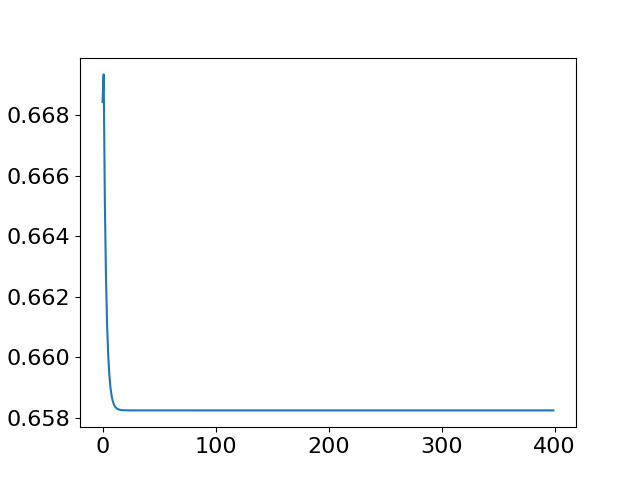

In [181]:

fig = plt.figure()
plt.plot(np.arange(0,400), errors)


#### Visual analysis of control model filters

### 3d visualization of neural activity

In [ ]:
%matplotlib notebook
def select_random_posture():
    posture = zeros(4)
    posture[0] = randrange(1,0,2*pi/3)
    posture[1] = randrange(1,0,2*pi/3)
    posture[2] = randrange(1,0,2*pi/3)
    return posture

def select_lin_posture(n):
    position = zeros((10*n*n, 4))
    phi1 = linspace(0,2*pi/3,n)
    phi2 = linspace(0,2*pi/3,n)
    theta1 = linspace(0,2*pi/3,n)
    xx, yy, zz = meshgrid(phi1, phi2, theta1)
    position[:,0] = xx.flatten()
    position[:,1] = yy.flatten()
    position[:,2] = zz.flatten()
    
    return position 

def select_lin_command(n):
    commands = zeros((10*n*n, 4))
    c0 = linspace(-1,1,n)*0.2
    c1 = linspace(-1,1,n)*0.2
    c2 = linspace(-1,1,n)*0.2
    cc0, cc1, cc2 = meshgrid(c0,c1,c2)
    commands[:,0] = cc0.flatten()
    commands[:,1] = cc1.flatten()
    commands[:,2] = cc2.flatten()
    
    return commands
    
def select_command():
    command = zeros(4)
    command[0] = randrange(1,-1, 1) * 0.25
    command[1] = randrange(1,-1, 1) * 0.25
    command[2] = random.choice(
        [-1, 1]) * np.sqrt(0.375 - (command[0] * command[0] + command[1] * command[1]))
    return command

def create_image_visu(posture, i):
    phi1, phi2, theta1 = posture[0], posture[1], posture[2]
    name = "visualization/%s" %i
    plot_arm(phi1, phi2, theta1, name)
    
def compute_random_activity_for_position(model, i):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    for k in (range(300)):
        posture_before = select_random_posture()
        position_before = control_robot(posture_before)
        name_before = "fig_before_%s" %k
        create_image_visu(posture_before, name_before)
        
        tmp0 = "images/visualization/" + name_before + ".png"
        
        tens_before = load_and_preprocess_image(tmp0)
        noised_tens_before = noised_image(tens_before)
        
        for j in range(10):
            res = []
            command = select_command()
            posture_after = posture_before + command
            position_after = control_robot(posture_after)
            name_after = "fig_after_%s_%s" %(k, j)
            create_image_visu(posture_after, name_after)
            
            tmp1 = "images/visualization/" + name_after + ".png"

            tens_after = load_and_preprocess_image(tmp1)
            noised_tens_after = noised_image(tens_after)
            
            t = tf.concat([noised_tens_before, noised_tens_after], -1)
            r = tf.reshape(t, [1,IMG_SIZE, IMG_SIZE, 2])
            
            
            output = model.predict(r)
            res.append(output[0][0][i])
        
        moy = mean(res)
       
        ax.scatter3D(position_before[0], position_before[1], position_before[2], color= plt.cm.Greens((moy) *2))
        
    plt.show()

def compute_activity_for_position(model, i):
    """ compute averaged-command initial-position specific neural activity
    
    Args : 
        model : a keras model object
        i : neuron index
    
    Returns : 
        null
    """
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    postures = select_lin_posture(10)
    command = select_command()
    for k in (range(100)):
        
        posture_before = postures[k]
        position_before = control_robot(posture_before)
        name_before = "fig_before_%s" %k
        create_image_visu(posture_before, name_before)
        
        tmp0 = "images/visualization/" + name_before + ".png"
        
        tens_before = load_and_preprocess_image(tmp0)
        noised_tens_before = noised_image(tens_before)
        
        for j in range(10):
            res = []
            
            posture_after = posture_before + command
            position_after = control_robot(posture_after)
            name_after = "fig_after_%s_%s" %(k, j)
            create_image_visu(posture_after, name_after)
            
            tmp1 = "images/visualization/" + name_after + ".png"

            tens_after = load_and_preprocess_image(tmp1)
            noised_tens_after = noised_image(tens_after)
            
            t = tf.concat([noised_tens_before, noised_tens_after], -1)
            r = tf.reshape(t, [1,IMG_SIZE, IMG_SIZE, 2])
            
            
            output = model.predict(r)
            res.append(output[0][0][i])
        
        moy = mean(res)
       
        ax.scatter3D(position_before[0], position_before[1], position_before[2], color= plt.cm.seismic((moy)))
        
    plt.show()
   

In [ ]:
%matplotlib notebook
def compute_loss_vd(model, pos_init, joint_command, filter_index):
    img = generate_input_from_vd(pos_init,  joint_command)
    output = model.predict(img)
    loss = output[0][0][filter_index]
    
    return loss

#@tf.function
def generate_img_from_pos(phi1, phi2, theta1):
    
    fig = figure(facecolor=(0.0, 0.0, 0.0))
    ax = fig.gca(projection='3d')
    phi1 = tf.cast(phi1, tf.float32)
    phi2 = tf.cast(phi2, tf.float32)
    theta1 = tf.cast(theta1, tf.float32)

    x = [0, 0, L1 * tf.math.cos(phi1) * tf.math.cos(theta1), L2 *
         tf.math.cos(phi1 + phi2) * tf.math.cos(theta1)]
    y = [0, 0, L1 * tf.math.cos(phi1) * tf.math.sin(theta1), L2 *
         tf.math.cos(phi1 + phi2) * tf.math.sin(theta1)]  # ELBOW + HAND
    z = [0, 0, L1 * tf.math.sin(phi1), L2 * tf.math.sin(phi1 + phi2)]  # ELBOW + HAND
   
    ax.grid(False)
    ax.set_facecolor((0.0, 0.0, 0.0))
    ax.set_xlim(left=-0.2, right=0.2)
    ax.set_ylim(bottom=-0.2, top=0.2)
    ax.set_zlim(bottom=-0.2, top=0.2)
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.plot(x, y, z, label='shoulder', lw=5, color='white')
    
    fig.canvas.draw()
    
    x = np.array(fig.canvas.renderer.buffer_rgba())
    x = np.reshape(x, (288,432,4))
    
    tmp = tf.image.resize(x, [IMG_SIZE, IMG_SIZE])
    #tmp = tf.reshape(tmp, [1,64,64,4])
    
    plt.close()
    
    return tmp


def generate_input_from_vd(pos_before, joint_command):

    pos_before = tf.reshape(pos_before, [1,4])
    img_before = generate_img_from_pos(pos_before[0][0],
                                      pos_before[0][1],
                                      pos_before[0][2])
    
    pos_after = np.add(pos_before , joint_command)
    img_after = generate_img_from_pos(pos_after[0][0],
                                      pos_after[0][1],
                                      pos_after[0][2])
    
    t =  tf.concat([img_before[:,:,:1], img_after[:,:,:1]], -1)
    t = tf.reshape(t, [1, IMG_SIZE, IMG_SIZE, 2])
    
    return t

def generate_max_vd(model, filter_index, nb_pass):
    
    list_pos_before = []
    list_loss = []
    list_joint_command = []

    for i in tqdm.tqdm(range(100)):
        
        joint_command = tf.convert_to_tensor(
            np.random.random((1,4)), dtype = 'float32')
        pos_before = tf.convert_to_tensor(
            np.random.random((1,4)), dtype='float32')

        tmp_loss = 0
        tmp_joint_command = joint_command
        
        list_pos_before.append(pos_before)
        j = 0
        #for j in (range(nb_pass)):
        while (tmp_loss < 10000) and (j < 100):
            new_joint_command = zeros((1,4))
            #new_joint_command[0][0] = random.choice([-1,-1])*randrange(1, 0, 0.2)
            #new_joint_command[0][1] = random.choice([-1,-1])*randrange(1, 0, 0.2)
            #new_joint_command[0][2] = random.choice([-1,-1])*randrange(1, 0, 0.2)
        
            new_joint_command[0][0] = random.choice([-1,1])*0.25
            new_joint_command[0][1] = random.choice([-1,1])*0.25
            new_joint_command[0][2] = random.choice([-1,1])*np.sqrt(
                0.375 -  (new_joint_command[0][0] * new_joint_command[0][0] + new_joint_command[0][1] * new_joint_command[0][1]))
            
            new_loss = compute_loss_vd(model, 
                                       pos_before, 
                                       new_joint_command, 
                                       filter_index)
            
            if (new_loss > tmp_loss) :
                tmp_loss = new_loss
                tmp_joint_command = new_joint_command
            #else : 
            #    pass
            j += 1
        list_loss.append(tmp_loss)
        list_joint_command.append(tmp_joint_command)
    
    return list_loss, list_joint_command, list_pos_before
            

In [ ]:
%matplotlib notebook
%matplotlib notebook  
def plot_max_vd(list_pos_before, list_joint_command, j):
    fig = figure(facecolor=(0.0, 0.0, 0.0))
    ax = fig.gca(projection='3d')
    for i in (range(len(list_loss))):
        
        if (list_loss[i] == 0) : #or (list_loss[i] < mean(list_loss)):
            pass
        else : 
            position_before = control_robot(list_pos_before[i][0])
            posture_after = np.add(list_pos_before[i][0],
                                   list_joint_command[i][0])
            position_after = control_robot(posture_after)
            plt.quiver(position_before[0], 
                       position_before[1], 
                       position_before[2], 
                       position_after[0], 
                       position_after[1], 
                       position_after[2], 
                       length = 0.1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    figtitle = 'Receptive field of visuomotor neuron %s' %j
    plt.title(figtitle)
    plt.show()
    title = 'images/receptive_fields/rf_%s.png' %j
    savefig(title)
%matplotlib notebook   
%matplotlib notebook

In [ ]:
%matplotlib notebook
plot_max_vd(list_pos_before, list_joint_command, i)

In [ ]:
def multiple_contribution(model, nb_pass):
    pos_before1 = tf.convert_to_tensor(
        np.random.random((1,4)), dtype='float32')
    pos_before2 = tf.convert_to_tensor(
        np.random.random((1,4)), dtype='float32')
    
    list_joint_cmd1 = []
    list_joint_cmd2 = []
    pos = []
    pos.append(pos_before1)
    pos.append(pos_before2)
    
    for i in tqdm.tqdm(range(32)):
        tmp_loss1 = 0
        tmp_loss2 = 0
        
        tmp_joint_command1 = zeros((1,4))
        tmp_joint_command2 = zeros((1,4))
        
        for j in range(nb_pass):
            new_joint_command1 = zeros((1,4))
            new_joint_command1[0][0] = random.choice([-1,1])*0.25
            new_joint_command1[0][1] = random.choice([-1,1])*0.25
            new_joint_command1[0][2] = random.choice([-1,1])*np.sqrt(
                0.375 -  (new_joint_command1[0][0] * new_joint_command1[0][0] + new_joint_command1[0][1] * new_joint_command1[0][1]))
          
        
            new_joint_command2 = zeros((1,4))
            new_joint_command2[0][0] = random.choice([-1,1])*0.25
            new_joint_command2[0][1] = random.choice([-1,1])*0.25
            new_joint_command2[0][2] = random.choice([-1,1])*np.sqrt(
                0.375 -  (new_joint_command2[0][0] * new_joint_command2[0][0] + new_joint_command2[0][1] * new_joint_command2[0][1]))
            
            loss1 = compute_loss_vd(model, pos_before1, new_joint_command1, i )
            loss2 = compute_loss_vd(model, pos_before2, new_joint_command2, i )
            
            if (loss1 > tmp_loss1):
                tmp_loss1 = loss1
                tmp_joint_command1 = new_joint_command1
            
            if (loss2 > tmp_loss2):
                tmp_loss2 = loss2
                tmp_joint_command2 = new_joint_command2
                
        list_joint_cmd1.append(tmp_joint_command1)
        list_joint_cmd2.append(tmp_joint_command2)
        
    return pos, list_joint_cmd1, list_joint_cmd2
            

In [ ]:
model_encoder = encoder_conv
pos, list_joint_cmd1, list_joint_cmd2 = multiple_contribution(model, 10)

In [ ]:
%matplotlib notebook
def plot_multiple_contrib(pos, list_joint_cmd1, indice):
    fig = figure(facecolor=(0.0,0.0,0.0))
    ax = fig.gca(projection="3d")
    
    for i in tqdm.tqdm(range(32)):
        position_before = pos[indice][0]
        posture_after = np.add(position_before, list_joint_cmd1[i][0])
        position_after = control_robot(posture_after)
        plt.quiver(position_before[0],
                  position_before[1], 
                  position_before[2], 
                  position_after[0], 
                  position_after[1], 
                  position_after[2], 
                  length = 0.1, 
                  color = plt.cm.Set1(i/32.0))
    plt.show()

In [ ]:
plot_multiple_contrib(pos, list_joint_cmd1, 0)

In [ ]:
plot_multiple_contrib(pos,list_joint_cmd2, 1)